In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
import itertools
from training import toy

In [2]:
batch_size = 1

trainset = toy.CubicToyDataset(min=-4, max=4, sample_count=20, noise=3)
trainloader = torch.utils.data.DataLoader(trainset, batch_size)

device = torch.device("cpu")

In [3]:
import matplotlib.pyplot as plt

def plot(eval):
    plt.xlim(-2, 2)
    plt.ylim(-3, 3)
    t = np.linspace(-2, 2, 50)

    plt.plot(t, t**3, color="blue") # Actual function

    means, deviations = np.zeros(len(t)), np.zeros(len(t))
    with torch.no_grad():
        for i, input in enumerate(t):
            mean, variance = eval(torch.tensor([[input]], dtype=torch.float))
            means[i], deviations[i] = mean.numpy(), variance.numpy()
    higher_bound = means + 3 * deviations
    lower_bound = means - 3 * deviations
    plt.plot(t, means, color="red") # Averaged predictions
    plt.fill_between(t, lower_bound, higher_bound, color="lightgrey")

    xs, ys = zip(*((x.numpy(), y.numpy()) for (x, y) in trainloader))
    plt.scatter(xs, ys, s=4, color="blue")

Epoch 0: loss 0.002496679313480854
Epoch 10: loss 0.023135846480727196
Epoch 20: loss 0.019542105495929718
Epoch 30: loss 0.017593778669834137
Final loss 0.01589973457157612


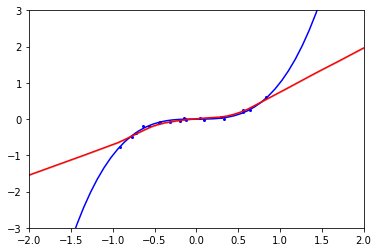

In [4]:
# Point estimator with L2 regularization

model = nn.Sequential(nn.Linear(1, 100), nn.ReLU(), nn.Linear(100, 1))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
for epoch in range(40):
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {loss}")
print(f"Final loss {loss}")
plot(lambda input: (model(input), torch.tensor(0)))

Epoch 0: loss 0.014747222885489464
Epoch 10: loss 0.017563732340931892
Epoch 20: loss 0.01689513772726059
Epoch 30: loss 0.015764055773615837
Epoch 40: loss 0.014323852024972439
Epoch 50: loss 0.012638064101338387
Epoch 60: loss 0.011118041351437569
Epoch 70: loss 0.009752889163792133
Epoch 80: loss 0.00859790202230215
Epoch 90: loss 0.007418886758387089
Final loss 0.006346880923956633


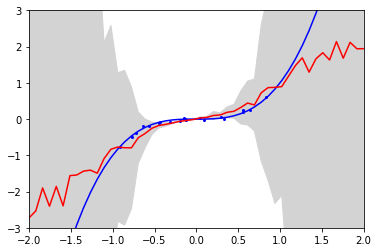

In [5]:
# SWAG trained with Adam and L2 regularization (lr is currently not adjusted for SWAG)

from training import swag
import importlib
importlib.reload(swag)

model = nn.Sequential(nn.Linear(1, 100), nn.ReLU(), nn.Linear(100, 1))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001) # Without weight_decay the covariance matrix is not positive definit???
wrapper = swag.SWAGWrapper(model, 5, 10)
for epoch in range(100):
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
    wrapper.update(epoch)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {loss}")
print(f"Final loss {loss}")

def eval_swag(input):
    return wrapper.sample(input, 100, model, 1)

plot(eval_swag)

Training model 0
  Final loss 0.01518096774816513
Training model 1
  Final loss 0.015052443370223045
Training model 2
  Final loss 0.011055625975131989
Training model 3
  Final loss 0.01848580129444599
Training model 4
  Final loss 0.01604723371565342


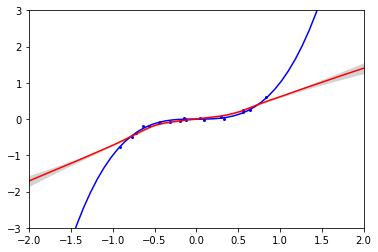

In [6]:
# Ensemble of point estimators with L2 regularization

models = [nn.Sequential(nn.Linear(1, 100), nn.ReLU(), nn.Linear(100, 1)) for _ in range(5)]
for i, model in enumerate(models):
    print(f"Training model {i}")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
    for epoch in range(40):
        for data, target in trainloader:
            optimizer.zero_grad()
            output = model(data)
            loss = F.mse_loss(output, target)
            loss.backward()
            optimizer.step()
        #if epoch % 10 == 0:
            #print(f"  Epoch {epoch}: loss {loss}")
    print(f"  Final loss {loss}")
        

def eval_esemble(input):
    outputs = torch.zeros(len(models))
    for i, model in enumerate(models):
        outputs[i] = model(input)
    return torch.mean(outputs), torch.var(outputs)
        

plot(eval_esemble)

Epoch 0: loss 56.9346923828125
Epoch 10: loss 47.98665237426758
Epoch 20: loss 46.26034927368164
Epoch 30: loss 47.413597106933594
Epoch 40: loss 45.67946243286133
Epoch 50: loss 44.25008773803711
Epoch 60: loss 42.12017822265625
Epoch 70: loss 43.70262908935547
Epoch 80: loss 43.027931213378906
Epoch 90: loss 44.50825500488281
Epoch 100: loss 43.95625686645508
Epoch 110: loss 44.22238540649414
Epoch 120: loss 41.8198356628418
Epoch 130: loss 41.061344146728516
Epoch 140: loss 42.00661849975586
Epoch 150: loss 40.297489166259766
Epoch 160: loss 43.27572250366211
Epoch 170: loss 41.23869323730469
Epoch 180: loss 40.976810455322266
Epoch 190: loss 41.3660888671875
Epoch 200: loss 39.01747131347656
Epoch 210: loss 40.74441146850586
Epoch 220: loss 40.962318420410156
Epoch 230: loss 42.09614181518555
Epoch 240: loss 38.56327819824219
Epoch 250: loss 38.57426071166992
Epoch 260: loss 40.22908401489258
Epoch 270: loss 38.05038070678711
Epoch 280: loss 39.47184753417969
Epoch 290: loss 37.620

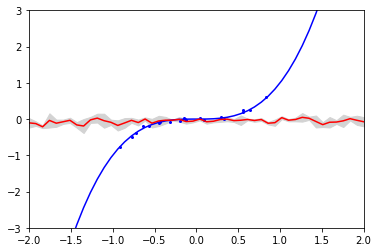

In [21]:
# Bayesian NN (Bayes-by-Backprop)

from training.util import GaussianMixture
import training.bbb as bbb
import importlib
importlib.reload(bbb)

pi = 0.5 # 0.25, 0.5, 0.75
sigma1 = np.exp(-1) # 0, 1, 2
sigma2 = np.exp(-7) # 6, 7, 8
prior = GaussianMixture(pi, sigma1, sigma2)

model = nn.Sequential(bbb.BayesianLinearLayer(1, 100, prior, prior, device), nn.ReLU(), bbb.BayesianLinearLayer(100, 1, prior, prior, device))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(1000):
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        #mean, variance = output[:,0], torch.log1p(torch.exp(output[:,1])) + 10e-6
        #dist = torch.distributions.Normal(mean, variance)
        log_prior = sum([getattr(layer, "log_prior", 0) for layer in model])
        log_posterior = sum([getattr(layer, "log_posterior", 0) for layer in model])
        loss = (log_posterior - log_prior) / len(trainloader) + F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {loss}")
print(f"Final loss {loss}")
        

def eval_bbb(input):
    outputs = torch.zeros(10)
    for i in range(len(outputs)):
        outputs[i] = model(input)[0,0]
    return torch.mean(outputs), torch.var(outputs)
        

plot(eval_bbb)